In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
N = 50  # Размер решетки
J = 1.0    # Энергия взаимодействия
thermalization = 100*N**2  # Шаги прогрева системы
steps = 100*N**2  # Шаги измерений
T = np.linspace(1.0, 4.0, 40) #Диапазон температур для исследования
T_c = 2.269 #Теоретическое значение температуры для фазового перехода

def energy(spins, J = 1.0):
    return -J/2 * np.sum(spins * (np.roll(spins, 1, axis=0) + np.roll(spins, 1, axis=1) + 
                                np.roll(spins, -1, axis=0) + np.roll(spins, -1, axis=1)))

def metropolis_step(spins, T, N):
    i, j = np.random.randint(0, N, 2)
    neighbors = spins[(i+1)%N,j] + spins[(i-1)%N,j] + spins[i,(j+1)%N] + spins[i,(j-1)%N]
    dE = 2 * spins[i,j] * neighbors
    if dE < 0 or np.random.rand() < np.exp(-dE/T):
        spins[i,j] *= -1
    return spins

In [61]:
spins = np.array([[1,-1,1],[1,1,-1],[-1,-1,-1]]) # Тестим на рандомной конфигурации, 
#видно, что в конце концов система приходит в состояние с минимальной энергией, 
#когда все спины востроены в одном направлении
for _ in range(10):
    metropolis_step(spins,1.5,3)
    print(energy(spins, J = 1.0), metropolis_step(spins,1.5,3))
    spins = metropolis_step(spins,1.5,3)

2.0 [[-1 -1  1]
 [ 1  1 -1]
 [-1 -1 -1]]
-2.0 [[-1 -1 -1]
 [ 1 -1 -1]
 [-1 -1 -1]]
-6.0 [[ 1 -1 -1]
 [ 1 -1 -1]
 [-1 -1 -1]]
-6.0 [[-1  1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
-10.0 [[-1  1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
-18.0 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
-18.0 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
-18.0 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
-18.0 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]
-18.0 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]]


In [54]:
magnetizations = [] # Массив для построения зависимости M(T)
T_array = np.linspace(1.0,4.0,20)
for T in T_array:
    print(f"Calculating T = {T:.2f}...")
    
    spins = np.random.choice([-1, 1], size=(N, N))
    
    for _ in range(thermalization): # Прогрев системы для того, чтобы она пришла в состояние т/д равновесия
        spins = metropolis_step(spins, T, N)
    
    mags = [] #Массив для того чтобы добавлять туда намагниченность M, которая реализуется в каждом из состояний
    for _ in range(steps):
        spins = metropolis_step(spins, T, N)
        mags.append(np.mean(spins))
    
    # Расчет термодинамических величин
    magnetization = np.mean(mags)
    magnetizations.append(magnetization)

Calculating T = 1.00...
Calculating T = 1.16...
Calculating T = 1.32...
Calculating T = 1.47...
Calculating T = 1.63...
Calculating T = 1.79...
Calculating T = 1.95...
Calculating T = 2.11...
Calculating T = 2.26...
Calculating T = 2.42...
Calculating T = 2.58...
Calculating T = 2.74...
Calculating T = 2.89...
Calculating T = 3.05...
Calculating T = 3.21...
Calculating T = 3.37...
Calculating T = 3.53...
Calculating T = 3.68...
Calculating T = 3.84...
Calculating T = 4.00...


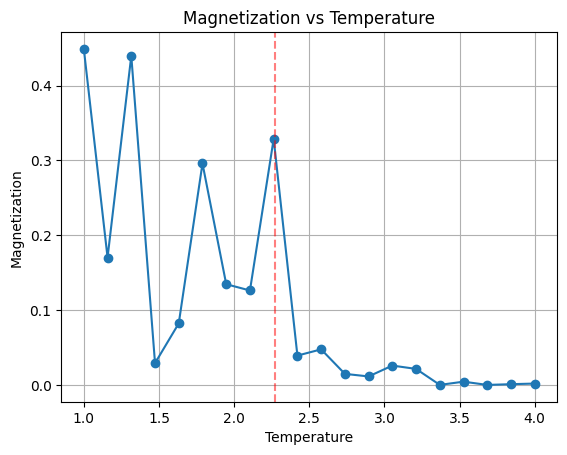

In [55]:
plt.plot(T_array, np.abs(magnetizations), 'o-')
plt.axvline(x=T_c, color='r', linestyle='--', alpha=0.5)
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.title("Magnetization vs Temperature")
plt.grid()

 С текущей функцией metropolis_step были получены правильные результаты (довольно четко видно наличие фазового перехода, когда система переходит в хаотическое неупорядоченное состояние и ее намагниченность $M \approx 0$). Однако, они далеки от идеала. Дело в том, что для довольно больших систем (N $\approx$ 100) число спинов $N^2 \approx 10^4$. За 1 шаг Метрополиса в данном случае меняется только состояние 1 агента, а всего их 10000. Для того чтобы система эволюционировала (из рандомно сгенерированного состояния при фиксированной температуре в равновесное состояние) потребуется огромное количество шагов. Поэтому, возникает идея немного изменить функцию metropolis_step с тем, чтобы за 1 шаг перебрать бОльшее количество состояний. Реализация с помощью средств NumPy

In [56]:
spins = np.array([[1,-1,1],
                  [1,1,-1],
                  [-1,-1,-1]])
spins[[1,1],[1,2]]

array([ 1, -1])

In [57]:
def metropolis_step2(spins, T, N, J = 1.0):
    i, j = np.random.randint(0, N, N**2), np.random.randint(0, N, N**2) # Генерируем сразу N^2
    neighbors = (np.roll(spins, 1, 0) + np.roll(spins, -1, 0) + #Считает сумму спинов всех 4 соседей для каждой ячейки
                np.roll(spins, 1, 1) + np.roll(spins, -1, 1))   #векторизованный аналог изначального подсчета соседей
    delta_E = 2 * spins[i,j] * (J * neighbors[i,j]) # теперь dE - вектор
    flag = (delta_E < 0) | (np.random.random(N**2) < np.exp(-delta_E/T)) # вектор из булеанов
    spins[i[flag], j[flag]] *= -1
    return spins

In [62]:
thermalization = 20000  # Шаги прогрева системы
steps = 30000  # Шаги измерений
magnetizations = [] # Массив для построения зависимости M(T)
susceptibilities = [] # Массив для зависимости xu(T)
T_array = np.linspace(1,4.0,40)
for T in T_array:
    print(f"Calculating T = {T:.2f}...")
    
    spins = np.random.choice([-1, 1], size=(N, N))
    
    for _ in range(thermalization): # Прогрев системы для того, чтобы она пришла в состояние т/д равновесия
        spins = metropolis_step2(spins, T, N)
    
    mags = [] #Массив для того чтобы добавлять туда намагниченность M, которая реализуется в каждом из состояний
    for _ in range(steps):
        spins = metropolis_step2(spins, T, N)
        mags.append(np.mean(spins))
    
    # Расчет термодинамических величин
    magnetization = np.mean(mags)
    magnetizations.append(magnetization)
    
    susceptibility = np.var(mags) * N**2 / T
    susceptibilities.append(susceptibility)

Calculating T = 1.00...
Calculating T = 1.08...
Calculating T = 1.15...
Calculating T = 1.23...
Calculating T = 1.31...
Calculating T = 1.38...
Calculating T = 1.46...
Calculating T = 1.54...
Calculating T = 1.62...
Calculating T = 1.69...
Calculating T = 1.77...
Calculating T = 1.85...
Calculating T = 1.92...
Calculating T = 2.00...
Calculating T = 2.08...
Calculating T = 2.15...
Calculating T = 2.23...
Calculating T = 2.31...
Calculating T = 2.38...
Calculating T = 2.46...
Calculating T = 2.54...
Calculating T = 2.62...
Calculating T = 2.69...
Calculating T = 2.77...
Calculating T = 2.85...
Calculating T = 2.92...
Calculating T = 3.00...
Calculating T = 3.08...
Calculating T = 3.15...
Calculating T = 3.23...
Calculating T = 3.31...
Calculating T = 3.38...
Calculating T = 3.46...
Calculating T = 3.54...
Calculating T = 3.62...
Calculating T = 3.69...
Calculating T = 3.77...
Calculating T = 3.85...
Calculating T = 3.92...
Calculating T = 4.00...


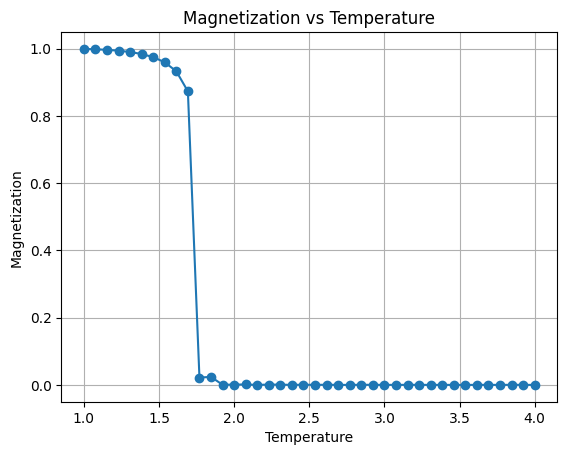

In [63]:
plt.plot(T_array, np.abs(magnetizations), 'o-')
plt.xlabel("Temperature")
plt.ylabel("Magnetization")
plt.title("Magnetization vs Temperature")
plt.grid()

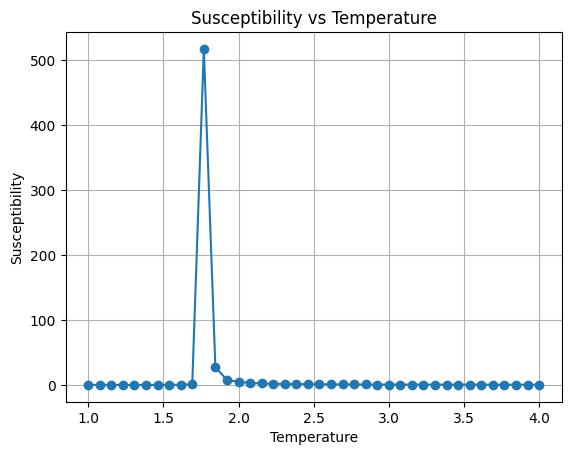

In [64]:
plt.plot(T_array, susceptibilities, 'o-')
plt.xlabel("Temperature")
plt.ylabel("Susceptibility")
plt.title("Susceptibility vs Temperature")
plt.grid()